In [1]:
#!/usr/bin/env python

In [2]:
import os
import sys
if os.path.exists('/home/chieh/code/wPlotLib'):
	sys.path.insert(0,'/home/chieh/code/wPlotLib')
if os.path.exists('/home/chieh/code/wuML'):
	sys.path.insert(0,'/home/chieh/code/wuML')

In [3]:
from proj_tools import *
import wuml
import numpy as np
import torch
import torch.nn as nn

In [4]:
denoising_threshold = 0.6

The penultimate layer of CE is the input of MSE with batch normalization<br>
Denoising autoencoder is added

In [5]:
def status_printing(all_losses, epoch, lr):
	if epoch > 1: wuml.clear_previous_line(10)
#
	[total_loss, L1 , L2 , L3 , C1 , C2 , β, α] = all_losses
	txt = '\tepoch: %d\n'%epoch
	txt += '\tlr: %.10f\n'%lr
	txt += '\tTotal Loss: %.4f\n'%total_loss
	txt += '\tMSE Loss: %.4f\n'%L2
	txt += '\tCE Loss: %.4f\n'%L3
	txt += '\tReconstruct Loss: %.4f\n'%L1
	txt += '\tAbove 42 error: %.4f\n'%C1
	txt += '\tBelow 22 error: %.4f\n'%C2
	txt += '\tType I error: %.4f\n'%α
	txt += '\tType II error: %.4f\n'%β
#
	wuml.write_to_current_line(txt)

You can also control the behavior of the network on call<br>
after creating cNet = wuml.combinedNetwork(...)<br>
define this allows you to call cNet(some_data) and return a behavior

In [6]:
def network_behavior_on_call(all_data, all_networks):
	enc = all_networks[0]
	dec = all_networks[1]
	ce_net = all_networks[2]
	mse_net = all_networks[3]
#
	#	the 1st 3 items of all_data will always be X, y, index
	#	the rest will be what you include
	X = all_data[0]
	y = all_data[1]				# MSE label
#
	# run data through the networks
	ŷᴬ = enc(X)
	ŷᴮ = dec(ŷᴬ)
	ŷᶜ = ce_net(ŷᴬ)
#
	ŷᴰ = torch.clamp(mse_net(ŷᴬ).squeeze(), min=23, max=41)
	#ŷᴰ = torch.clamp(mse_net(ŷᶜ).squeeze(), min=23, max=41)		# use ce output
#
#
	prob = wuml.softmax(ŷᶜ)
	_, ŷᶜ = torch.max(ŷᶜ, 1)
	return [ŷᶜ, prob, ŷᴰ]

In [7]:
def costFunction(all_data, all_networks):	
	enc = all_networks[0]
	dec = all_networks[1]
	ce_net = all_networks[2]
	mse_net = all_networks[3]
#
	#	the 1st 3 items of all_data will always be X, y, index
	#	the rest will be what you include
	X = all_data[0]
	y = all_data[1]				# MSE label
	indx = all_data[2]
	y2= all_data[3].squeeze()				# CE label
#
	msk = (torch.rand(X.shape) < denoising_threshold).long()
	msk = wuml.ensure_tensor(msk, dataType=torch.FloatTensor)
	Xin = torch.mul(X, msk)
#
	# run data through the networks
	ŷᴬ = enc(Xin)
	ŷᴮ = dec(ŷᴬ)
	ŷᶜ = ce_net(ŷᴬ)
	ŷᴰ = mse_net(ŷᴬ).squeeze()
	#ŷᴰ = mse_net(ŷᶜ).squeeze()		# use ce output
#
	n = X.shape[0]
	d = X.shape[1]
	relu = nn.ReLU()
#
	L1 = 1*1.0*wuml.MSELoss(X, ŷᴮ)										# autoencoder reconstruction loss
	L2 = 1*wuml.MSELoss(y, ŷᴰ)												# Regression loss
	L3 = 1*1*wuml.CrossEntropyLoss(y2, ŷᶜ)								# CE loss
	C1 = 1*2.2*torch.sum(relu((ŷᴰ - 42)))/n								# if prediction above 43, its wrong Constraint
	C2 = 1*2.2*torch.sum(relu((23 - ŷᴰ))/n)								# if prediction below 22, its wrong Constrain
	α  = 1*2.6*torch.sum(torch.mul(relu(y - 37), relu(37-ŷᴰ)))/n		# if mature, penalize premature predictions type 1 error
	β  = 1*2.5*torch.sum(torch.mul(relu(37-y), relu(ŷᴰ - 37)))/n
#
	total_loss = L1 + L2 + L3 + C1 + C2 + α + β
	return [total_loss, L1 , L2 , L3 , C1 , C2 , β , α]

This data has both regression and classification labels (3 classes)<br>
the network will train on both labels by<br>
	using the 1st network to get 3 softmax outputs, <br>
	from the 1st network, it will connect to the 2nd network, <br>
		expand to width of 5 and compress down to 1 for regression

In [8]:
data = wuml.wData(xpath='./data/D3_Imputed_Balanced_regression.csv', batch_size=32, 
					label_type='continuous', label_column_name='gestationAge',
					mv_columns_to_extra_data='preterm_best',
					first_row_is_label=True)

In [9]:
[X_train, X_test, y_train, y_test] = wuml.split_training_test(data, test_percentage=0.2)
X_train.Data_preprocess()
X_test.Data_preprocess(mean=X_train.μ, std=X_train.σ)

In [10]:
bottleneck_size = 40
d = X_train.shape[1]

In [11]:
width = 60
netStructureList = []
netStructureList.append([(width,'relu'),('bn', True),(width,'relu'),('bn', True),(width,'relu'),('bn', True),(bottleneck_size,'none')])
netStructureList.append([(bottleneck_size,'relu'),(width,'relu'),(width,'relu'),(width,'relu'),(200,'relu'),(d,'none')])
netStructureList.append([(2,'none')])	#CE objective
netStructureList.append([(width,'relu'),('bn', True),(width,'relu'),('bn', True),(1,'none')])	#MSE objective
netStructureList.append([(1,'none')])	#MSE objective
#netInputDimList = [d, bottleneck_size, bottleneck_size, 2]
netInputDimList = [d, bottleneck_size, bottleneck_size, bottleneck_size]

In [12]:
cNet = wuml.combinedNetwork(X_train, netStructureList, netInputDimList, costFunction, force_network_to_use_CPU=True,
							max_epoch=4, on_new_epoch_call_back=status_printing,
							network_behavior_on_call=network_behavior_on_call, learning_rate=0.001, lr_decay_rate=0.5,
							Y_dataType=torch.FloatTensor, extra_dataType=[torch.LongTensor]) 

All Networks
	Batch size: 32: 
	Learning rate: 0.001
	Max number of epochs: 4
	Cost Function: costFunction
	Train Loop Callback: status_printing
	Device type: 'cpu'
	Networks 0 Structure
		Linear(in_features=32, out_features=60, bias=True) , relu
		BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
		Linear(in_features=60, out_features=60, bias=True) , relu
		BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
		Linear(in_features=60, out_features=60, bias=True) , relu
		BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
		Linear(in_features=60, out_features=40, bias=True) , none
	Networks 1 Structure
		Linear(in_features=40, out_features=40, bias=True) , relu
		Linear(in_features=40, out_features=60, bias=True) , relu
		Linear(in_features=60, out_features=60, bias=True) , relu
		Linear(in_features=60, out_features=60, bias=True) , relu
		Linear(in_features=60, out_features=200, bias=True) , relu
	

	epoch: 4
	lr: 0.0010000000
	Total Loss: 563.9393
	MSE Loss: 483.2652
	CE Loss: 0.6346
	Reconstruct Loss: 1.6094
	Above 42 error: 0.0000
	Below 22 error: 16.5314
	Type I error: 61.8987
	Type II error: 0.0000


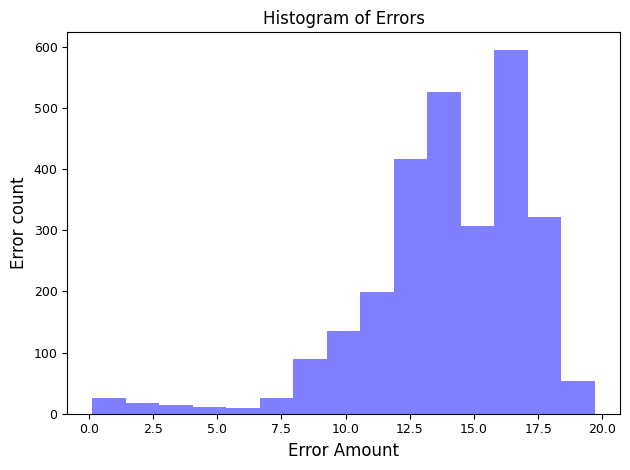


	---------------------

	 Classifier Accuracy : 0.6576
	 Classifier Precision: 0.6648
	 Classifier Recall: 0.6667
	 Classifier AUC: 0.7107
	 Regressor accuracy: 0.5115
	 Regressor Precision: 0.5115
	 Regressor Recall: 1.0000
	 Mean absolute error: 13.9507



,y,ŷ,Δy,yᶜ,ŷᶜ,Δyᶜ,P(X=1),yᴿ,ŷᴿ,Δyᴿ
1570,42.7,23.0,19.7,0,0,0,0.3934,0,1,1
2640,42.7,23.0,19.7,0,0,0,0.3200,0,1,1
1602,42.7,23.0,19.7,0,1,1,0.6128,0,1,1
1251,42.7,23.0,19.7,0,1,1,0.6427,0,1,1
1923,42.6,23.0,19.6,0,0,0,0.3516,0,1,1
1759,42.4,23.0,19.4,0,0,0,0.3771,0,1,1
1886,42.4,23.0,19.4,0,1,1,0.5795,0,1,1
767,42.3,23.0,19.3,0,1,1,0.5548,0,1,1
1509,42.3,23.0,19.3,0,0,0,0.4799,0,1,1
1250,42.1,23.0,19.1,0,0,0,0.3330,0,1,1


In [13]:
cNet.fit()
#y = cNet(X_train[0,:])
#wuml.save_torch_network(cNet, './D3_' + str(width) + '_' + str(denoising_threshold) + '.pk')
#
#	Training
[labels, prob_of_positive, gestages] = cNet(X_train, output_type='ndarray')
display_results(X_train.Y, gestages, X_train.xDat[0], labels, prob_of_positive)

	Test<br>
labels, prob_of_positive, gestages] = cNet(X_test, output_type='ndarray')<br>
isplay_results(X_test.Y, gestages, X_test.xDat[0], labels, prob_of_positive)